In [2]:
!pip install tensorflow

In [38]:
import keras

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

This notebook uses keras and the tensorflow backend to do character recognition on the MNIST digits.  You need to have the `keras` and `tensorflow` packages installed.  Also for visualization of the network, you need to have `pydot` installed.

We folow the example for setting up the network:
https://github.com/Vict0rSch/deep_learning/tree/master/keras/feedforward

# The MNIST data

The keras library can download the MNIST data directly and provides a function to give us both the training and test images and the corresponding digits.

In [39]:
from keras.datasets import mnist

In [40]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Notice that the training set consists of 60000 digits represented as a 28x28 array (there are no color channels, so this is grayscale data).  They are also integer data.

In [41]:
X_train.shape
#y_test.shape

(60000, 28, 28)

In [42]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Let's look at the first 10 digits and the "y" value (target) associated with it&mdash;that's the correct answer.

5
0
4
1
9
2
1
3
1
4


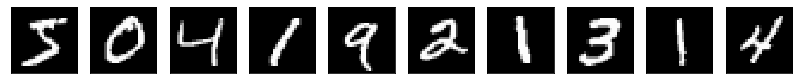

In [43]:
plt.figure(1, figsize=(14,3))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
for i in range(10):
    print(y_train[i])

## Preparing the Data


The neural network takes a 1-d vector of input and will return a 1-d vector of output.  We need to convert our data to this form.

We'll scale the image data to fall in [0, 1) and the numerical output to be categorized as an array.  Finally, we need the input data to be one-dimensional, so we fill flatten the 28x28 images into a single 784 vector.

In [44]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = np.reshape(X_train, (60000, 784))
X_test = np.reshape(X_test, (10000, 784))

In [45]:
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     


For the targets (y), we need to convert the output to an array that matches what we expect the output of the neural network to be.  keras includes routines to categorize data.  In our case, since there are 10 possible digits, we want to put the output into 10 categories (represented by 10 neurons)

In [46]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

Now let's look at the target for the first training digit.  We know from above that it was '5'.  Here we see that there is a `1` in the index corresponding to `5` (remember we start counting at `0` in python).

In [47]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

# Build the Neural Network

Now we'll build the neural network.  We will have 2 hidden layers, and the number of neurons will look like:

784 &rarr; 500 &rarr; 300 &rarr; 10

We will use a **dense** network.  This means that all neurons in one layer are connected to all neurons in the next layer (sometimes the term "fully-connected" is used here).

For each layer, we tell keras the number of output neurons.  It infers the number of inputs from the previous layer (with the exception of the input layer, where we need to tell it what to expect as input).

Also, for each layer, we specify the **activation** function.  We can use "sigmoid" or some other choices.  We'll use
the the _rectified linear unit_ activation function (see http://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#relu) for all but the last layer.  See https://keras.io/activations/ for a list of activation functions supported.

Finally, for some of the layers, we will specify a **dropout**.  This means that we will ignore some of the neurons in a layer during training (randomly selected at the specified probability).  This can help present overfitting of the network.  Here's a nice discussion: https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5

For the very last layer (the output layer), we use a `softmax` activation.  This is commonly used with categorical data (like we have) and has the nice property that all of entries add to 1 (so we can interpret them as probabilities).

In [48]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

model = Sequential()
model.add(Dense(500, input_dim=784))
model.add(Activation('sigmoid'))
#model.add(Dropout(0.4))
#model.add(Dense(300))
model.add(Activation('sigmoid'))
#model.add(Dropout(0.4))
model.add(Dense(10))
model.add(Activation('softmax'))

In [56]:
!pip install pydot
!pip install graphviz

Let's look at the network

In [58]:
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

def visualize_model(model):
  return SVG(model_to_dot(model,show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

#create your model
#then call the function on your model
visualize_model(model)


('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


AttributeError: 'NoneType' object has no attribute 'create'

We need to specify what we want to optimize and how we are going to do it.  

The loss (or objective) function measures how well our predictions match the expected target (an example can be the root-mean-square of the error).  For category data, like we have, the "cross-entropy" metric is often used.  See here for an explanation: https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/

We also need to specify an optimizer.  This could be like gradient descent.  Here's a list of the optimizers supoprted by keras: https://keras.io/optimizers/  We'll use `RMPprop`.

Finally, we need to specify a metric that is evaluated during training and testing.  We'll use `"accuracy"` here.  This means that we'll see the accuracy of our model reported as we are training and testing.

More details on these options is here: https://keras.io/models/model/

In [64]:
from IPython.display import clear_output
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_acc'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
             # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure()
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [65]:
rms = RMSprop()
model.compile(loss='categorical_crossentropy',
              optimizer=rms, metrics=['accuracy'])

# Train

For training, we pass in the inputs and target and the number of epochs to run and it will optimize the network by adjusting the weights between the nodes in the layers.

The number of epochs is the number of times the entire data set is passed forward and backward through the network.  The batch size is the number of training pairs you pass through the network at a given time.  You update the parameter in your model (the weights) once for each batch.  This makes things more efficient and less noisy.

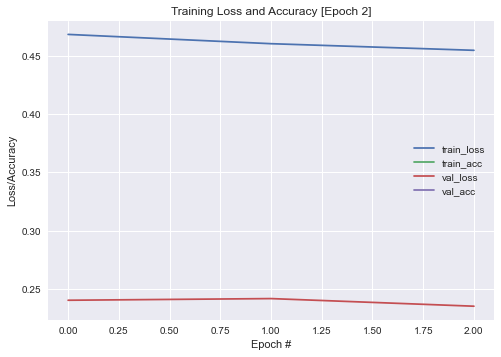

Epoch 4/20


In [ ]:
epochs = 20
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
          validation_data=(X_test, y_test), verbose=2, callbacks=[plot_losses])


# Test

keras has a routine, `evaluate()` that can take the inputs and targets of a test data set and return the loss value and accuracy (or other defined metrics) on this data.

Here we see we are > 98% accurate on the test data&mdash;this is the data that the model has never seen before (and was not trained with).

In [ ]:
loss_value, accuracy = model.evaluate(X_test, y_test, batch_size=16)
print(accuracy)

# Predicting

Suppose we simply want to ask our neural network to predict the target for an input.  We can use the `predict()` method to return the category array with the predictions.  We can then use `np.argmax()` to select the most probable.  Alternately, we can use `predict_classes()` to return the class (index) with the highest probability.

In [ ]:
model.predict_classes(np.array([X_test[0]]))

In [ ]:
y_test[0]

Now let's loop over the test set and print out what we predict vs. the true answer for those we get wrong.  We can also plot the image of the digit.

In [ ]:
for n, (x, y) in enumerate(zip(X_test, y_test)):
    try:
        res = model.predict(np.array([x]), verbose=0)
        if np.argmax(res) != np.argmax(y):
            print("test {}: prediction = {}, truth is {}".format(n, np.argmax(res), np.argmax(y)))
            plt.imshow(x.reshape(28, 28), cmap="gray_r")
            plt.show()
    except KeyboardInterrupt:
        print("stopping")
        break


# Exercises

## Q1: Batch size

Adjust the batch size&mdash;how does this affect the time it takes to train for an epoch?

## Q2: Hidden layers

Remove one of the hidden layers&mdash;how does the accuracy change?

## Q3: Dropout

What happens to the accuracy if you don't include any dropouts?

## Q4: Activation

How does the network perform using a `"sigmoid"` activation function?

## Q5: Callbacks

keras allows for callbacks each epoch to store some information.  Make a plot of the accuracy vs. epoch by adding a callback.  Take a look here for some inspiration:

https://keras.io/callbacks/#example-recording-loss-history

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

# Going Further

Convolutional neural networks are often used for image recognition, especially with larger images.  They use filter to try to recognize patterns in portions of images (A tile).  See this for a keras example: http://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/

In [32]:
3.25*3+(0.44*3.6)

11.334

In [33]:
9/73

0.1232876712328767